A Predictive Analysis of Heart Disease

We are using a data set from a Cleveland database with various measurements of variables correlated to heart disease, where a 1-4 indicates presence and 0 indicates absence in the num variable. Our goal is to create a predictive classifier that will allow us to take a set of values or measurements with an unknown class and predict whether or not it could indicate the development or presence of heart disease in an individual. The question we are looking to answer is ‘If we are given an observation with a set of unknown values, would we be able to create a classifier that can predict whether someone has/is at risk of developing heart disease or is healthy?' 
The data set that will be used to answer this question is the cleveland_data set; it has values for the following variables:

age: age in years
sex: sex(1 = male, 0 = female)
cp: chest pain type
-Value 1: typical angina
-Value 2: atypical angina
-Value 3: non-anginal pain
-Value 4: asymptomatic 
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholesterol in mg/dl 
fbs:(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
restecg: resting electrocardiographic results
-Value 0: normal
-Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
-Value 1: upsloping
-Value 2: flat
-Value 3: downsloping
ca: number of major vessels (0-3) colored by fluoroscopy
thal: 3 = normal; 6 = fixed defect; 7 = reversible defect 
num: diagnosis of heart disease (angiographic disease status)
-Value 0: < 50% diameter narrowing
-Value 1: > 50% diameter narrowing

Some of which will be used to help us make our predictive classifier. The names have been slightly altered within the classifier in order to make it more comprehensible. Although there are character equivalents to many of the numerical values used in this data set, as shown above, it will remain numerical throughout the report in order to create the classifier. These values will also be slightly altered when scaled. 

In [34]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)
library(GGally)
library(ISLR)

Here the appropriate libraries are loaded in order to create the visualizations, tables, classifier, etc. used within this report

In [12]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "cleveland_data")

Our file of choice was downloaded from an external source as a comma separated values file and renamed cleveland_data for use within the Jupyter notebook. 

In [13]:
heart_disease_data <- read_delim("cleveland_data", col_names = FALSE, skip=20, delim= ",")
heart_disease_data

Rows: 283 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table 1.0: Raw Data Set

Here is the visualization of the data table that we just downloaded, the first 20 lines have been skipped to get to the true data set and the column names were set to false because they do not exist in this data set.

In [14]:
names(heart_disease_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fasting_blood_sugar", "resting_electro", "max_hr", "ex_angina", "oldpeak", "slope", "ca", "thal", "num")
heart_disease_data <- heart_disease_data |>
mutate(num = case_when(num == 0 ~ "Healthy" , num == 1 ~ "Sick", num == 2 ~ "Sick", num == 3 ~ "Sick", num == 4 ~ "Sick"))|>
mutate(num = as_factor(num))
heart_disease_data$ca[heart_disease_data$ca == "?"] <- NA
heart_disease_data$thal[heart_disease_data$thal == "?"] <- NA
heart_disease_data

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,Healthy
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,Healthy
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,Sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,Sick
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,Sick
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,Healthy


Table 1.1: Data Set with Column Titles 

Here is where we added column names in the order that they appeared. We changed the class variable of "num" from a numerical value to a factor and renamed the number equivalents for each diagnosis in order to prepare for the classification. Any variables with "?" as a value were also changed to "NA" in order to make it easier to remove as we continue to wrangle our data.

In [27]:
heart_disease_data2 <- (na.omit(heart_disease_data))

heart_disease_data3 <- heart_disease_data2|>
mutate(thal = as.numeric(thal))|>
mutate(ca = as.numeric(ca))
heart_disease_data3

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
64,1,1,110,211,0,2,144,1,1.8,2,0,3,Healthy
58,0,1,150,283,1,2,162,0,1.0,1,0,3,Healthy
58,1,2,120,284,0,2,160,0,1.8,2,0,3,Sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,Sick
57,1,4,130,131,0,0,115,1,1.2,2,1,7,Sick
57,0,2,130,236,0,2,174,0,0.0,2,1,3,Sick


Table 1.2: Wrangled Data Set

Here we removed all rows containing "NA" as a value so that missing data does not negatively impact our classification. All the variables were also changed to numeric. 

In [16]:
scaled_recipe <- recipe(num ~ ., data = heart_disease_data3)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled <- scaled_recipe |>  
    prep() |> 
    bake(heart_disease_data3)
heart_data_scaled

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.034985,0.6981985,-2.248337,-1.1949675,-0.6930261,-0.4040717,1.001856,-0.2187793,1.415489,0.65826822,0.6868786,-0.7358115,-0.8929336,Healthy
0.377437,-1.4270869,-2.248337,1.0317798,0.6730258,2.4658737,1.001856,0.5581676,-0.703919,-0.02561475,-0.9821159,-0.7358115,-0.8929336,Healthy
0.377437,0.6981985,-1.212082,-0.6382806,0.6919987,-0.4040717,1.001856,0.4718402,-0.703919,0.65826822,0.6868786,-0.7358115,-0.8929336,Sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.4733496,0.6981985,0.8604283,0.69776774,-1.0345391,2.4658737,-1.009116,-0.3482704,-0.703919,2.0260342,0.6868786,1.3873112,1.1639696,Sick
0.2678458,0.6981985,0.8604283,-0.08159381,-2.2108616,-0.4040717,-1.009116,-1.4705270,1.415489,0.1453560,0.6868786,0.3257499,1.1639696,Sick
0.2678458,-1.4270869,-1.2120816,-0.08159381,-0.2187026,-0.4040717,1.001856,1.0761322,-0.703919,-0.8804685,0.6868786,0.3257499,-0.8929336,Sick


Table 1.3: Scaled and Centered Data Set

Data was scaled and centered, once that was completed it was prepped which is used to save the processed data and baked in order to apply the saved recipe we created earlier to the data set we want. 

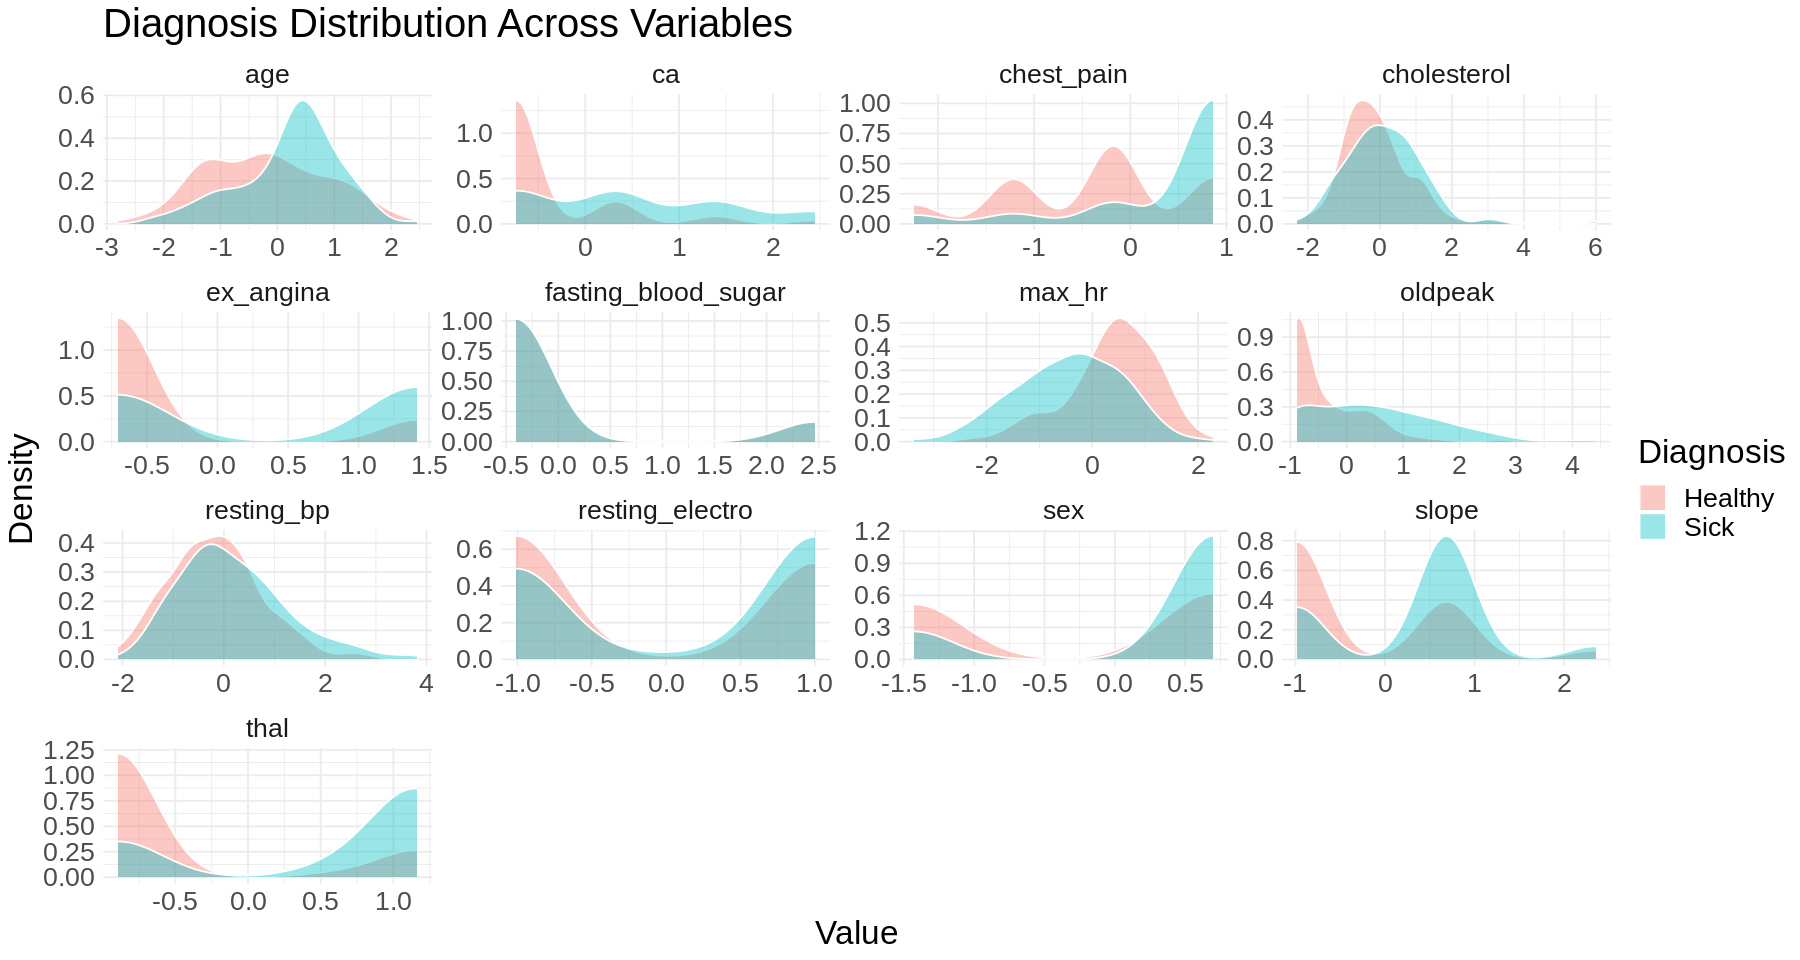

In [37]:
options(repr.plot.height = 8, repr.plot.width = 15)
heart_data_scaled|>
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        labs(fill = "Diagnosis", x = "Value", y = "Density")+
        ggtitle("Diagnosis Distribution Across Variables")+
        theme(text = element_text(size = 20))

Figure 1.0: Diagnosis Distribution Across Variables

In order to better identify the correlation between the variables in the data set and the diagnosis that was given we plotted each variable against density, and color coded the regions that indicate healthy and sick, this shows us where most of the points lie, and therefore which ones are best to be used in our classifier. The less overlap, the better the variable will be in classifying the new observation. 

In [18]:
heart_clean <- heart_data_scaled |>
select("age", "sex", "oldpeak", "chest_pain", "max_hr", "thal", "ex_angina", "ca", "num")
heart_clean

age,sex,oldpeak,chest_pain,max_hr,thal,ex_angina,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.034985,0.6981985,0.65826822,-2.248337,-0.2187793,-0.8929336,1.415489,-0.7358115,Healthy
0.377437,-1.4270869,-0.02561475,-2.248337,0.5581676,-0.8929336,-0.703919,-0.7358115,Healthy
0.377437,0.6981985,0.65826822,-1.212082,0.4718402,-0.8929336,-0.703919,-0.7358115,Sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.4733496,0.6981985,2.0260342,0.8604283,-0.3482704,1.1639696,-0.703919,1.3873112,Sick
0.2678458,0.6981985,0.1453560,0.8604283,-1.4705270,1.1639696,1.415489,0.3257499,Sick
0.2678458,-1.4270869,-0.8804685,-1.2120816,1.0761322,-0.8929336,-0.703919,0.3257499,Sick


Table 1.4: Selected Variables

Here we selected the variables from the data set that we decided to use for our classification. As we mentioned earlier, the variables were chosen based on which ones had the least overlap graphically, but from the ones that we chose this isn't completely true. This is because when choosing the ones with the least overlap, the classifier was doing a much better job at predicting healthy rather than sick individuals. Due to this we wanted to add predictor variables that not only showed less overlap, but also had more space taken up graphically by sick individuals, strengthening our classifier in that way. This is evident with sex, while there is quite a bit of overlap, most of the graph is dedicated to sick individuals, influencing our classifier. 

In [19]:
heart_disease_split <- initial_split(heart_clean, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

This is where we split our scaled and centered data into a training and test set, this makes it so that we can train our classifier but also test it without necessarily having a completely new data set.

In [20]:
heart_disease_table <- heart_disease_train |>
group_by(num)|>
summarize(chest_pain = mean(chest_pain, na.rm = TRUE),
    thal = mean(thal, na.rm = TRUE),
    ex_angina = mean(ex_angina, na.rm = TRUE),
    oldpeak = mean(oldpeak, na.rm = TRUE),
    sex = mean(sex, na.rm = TRUE),
    ca = mean(ca, na.rm = TRUE),
    age = mean(age, na.rm = TRUE),
    max_hr = mean(max_hr, na.rm = TRUE))
heart_disease_table

num,chest_pain,thal,ex_angina,oldpeak,sex,ca,age,max_hr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy,-0.3924982,-0.4581791,-0.3956414,-0.3908704,-0.2291988,-0.3883914,-0.1974189,0.4632074
Sick,0.3262763,0.5437178,0.3011612,0.3788985,0.3914562,0.4023574,0.2294324,-0.4572922


Table 1.5: Mean Values of Selected Variables

While this wasn't necessary for the classification itself, we summarized the mean of all of our chosen variables so see if there were any evident patterns, or things that stuck out to use that might assist in how we build our classifier, one thing being that most of the means for a healthy individual lie in the negative region, something we made note of.  

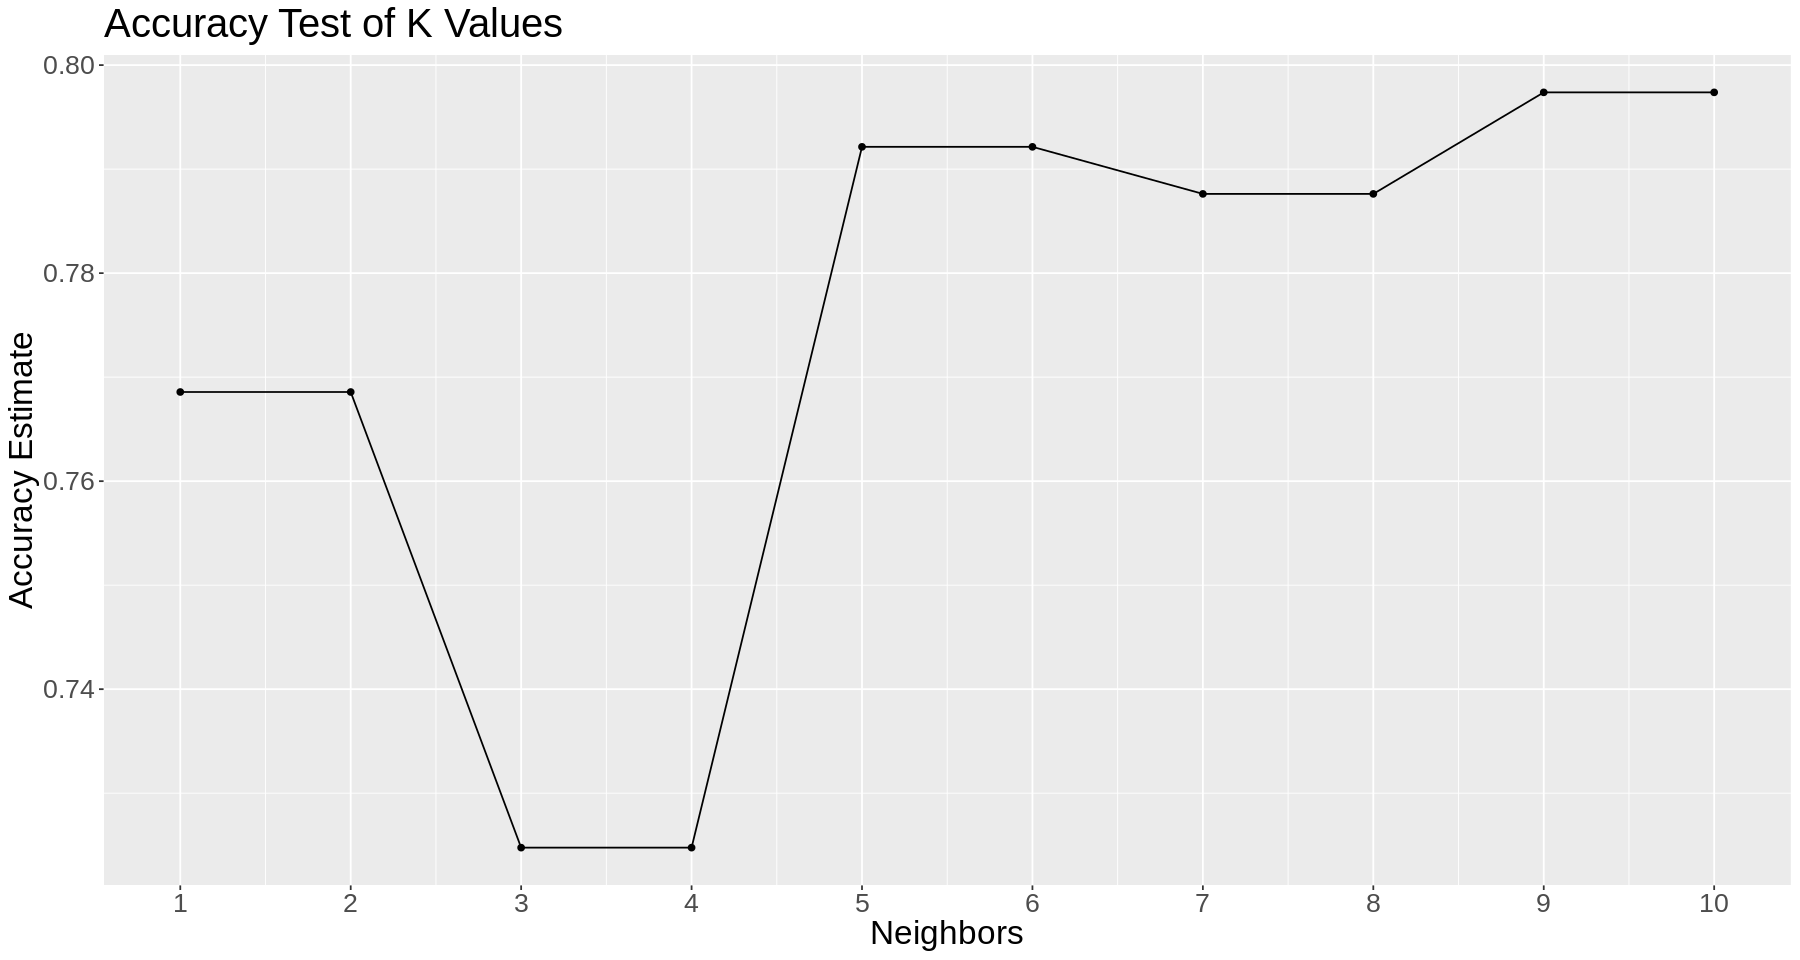

In [38]:
set.seed(2019) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

training_recipe <- recipe(num ~ ., data = heart_disease_train)

training_vfold <- vfold_cv(heart_disease_train, v = 10, strata = num)

grid_frame <- tibble(neighbors = (c(1,2,3,4,5,6,7,8,9,10)))

knn_results <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = training_vfold, grid = grid_frame) |>
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 10, by = 1))+
    ggtitle("Accuracy Test of K Values")+
    theme(text = element_text(size = 20))
cross_val_plot

Figure 1.1: Accuracy Test of Various K Values 

Here is where we train our classifier. We set the seed here so that it returns the same set of random numbers each time. Since this is a classification we are using k-nearest classification, and setting our neighbors to tune in order to find the best k value for our classifier. We then did a cross-fold validation in order to test our classifier against itself. We created a data frame of arbitrary k values and then tested it using the parameters that we created above. The results were then graphed, giving the above plot. The higher the accuracy estimate on the plot, the better the k value, here we can see that 9 is the best k value as it maximizes accuracy while minimizing the number of neighbors. 

In [28]:
set.seed(2019) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_disease_train)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1980676
Best kernel: rectangular
Best k: 9

Using the chosen k from above, an new classification specification was created, it was then added to a fit so create the parameters that will be used in our classifier

In [29]:
set.seed(2019) 

heart_predictions <- predict(heart_fit , heart_disease_test) |>
    bind_cols(heart_disease_test)
heart_predictions
      
heart_metrics <- heart_predictions |>
    metrics(truth = num, estimate = .pred_class)             
heart_metrics

heart_conf_mat <- heart_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
heart_conf_mat

.pred_class,age,sex,oldpeak,chest_pain,max_hr,thal,ex_angina,ca,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Sick,1.0349846,0.6981985,0.6582682,-2.2483366,-0.2187793,-0.8929336,1.415489,-0.7358115,Healthy
Sick,0.3774370,0.6981985,1.8550634,-0.1758267,1.0329685,1.1639696,-0.703919,1.3873112,Sick
Sick,0.5966196,0.6981985,1.1711804,0.8604283,-0.7367438,1.1639696,1.415489,1.3873112,Sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Healthy,1.254167,-1.4270869,-0.8804685,-0.1758267,0.1265305,-0.8929336,-0.703919,0.3257499,Healthy
Sick,0.377437,-1.4270869,1.5131219,0.8604283,-0.1324518,0.6497438,1.415489,1.3873112,Sick
Healthy,-1.485614,0.6981985,-0.8804685,-1.2120816,1.4214419,-0.8929336,-0.703919,-0.7358115,Healthy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8857143
kap,binary,0.7714286


          Truth
Prediction Healthy Sick
   Healthy      32    3
   Sick          5   30

Table 1.6: Predicted Class for Test Set

Table 1.7: Accuracy Metrics for Classifier

Table 1.8: Confusion Matrix for Classifier

Here is where the actual prediction occurs, the test set was run with the classifier we created above. We then collected the metrics of accuracy of our classifier showing that it is about 89% accurate. From here we created a confusion matrix which displays the amount of predictions that were accurate and which were false more clearly.

In [24]:
heart_proportions <- heart_disease_train |>
group_by(num) |>
summarize(n = n()) |>
mutate(percent = 100*n/nrow(heart_disease_train))
heart_proportions

num,n,percent
<fct>,<int>,<dbl>
Healthy,110,53.1401
Sick,97,46.8599


Table 1.9: Percentage of Each Class within Training Data Set

In order to decide whether this amount of accuracy was appropriate we compared it to the majority classifier. This shows us that if the classifier were to make all of its predictions just based off the majority of points it would return 53% accuracy every time. This makes our classifier significantly better than the majority. Despite this, we are predicting the presence and absence of heart disease, so while this percentage is fairly high for accuracy, it can always be improved. 

In [30]:
conf <- structure(c(32, 5, 3, 30, 0.86486486, 0.90909091
), .Dim = 2:3, .Dimnames = list(c("Healthy_p", "Sick_p"), c("Healthy", 
"Sick", "class.error")))
conf

,Healthy,Sick,class.error
Healthy_p,32,3,0.8648649
Sick_p,5,30,0.9090909


Table 2.0: Reformatted Confusion Matrix 

Here we reformated our confusion matrix in order to make visualization of our results easier. This has to be done manually for each time the classifier is run. 

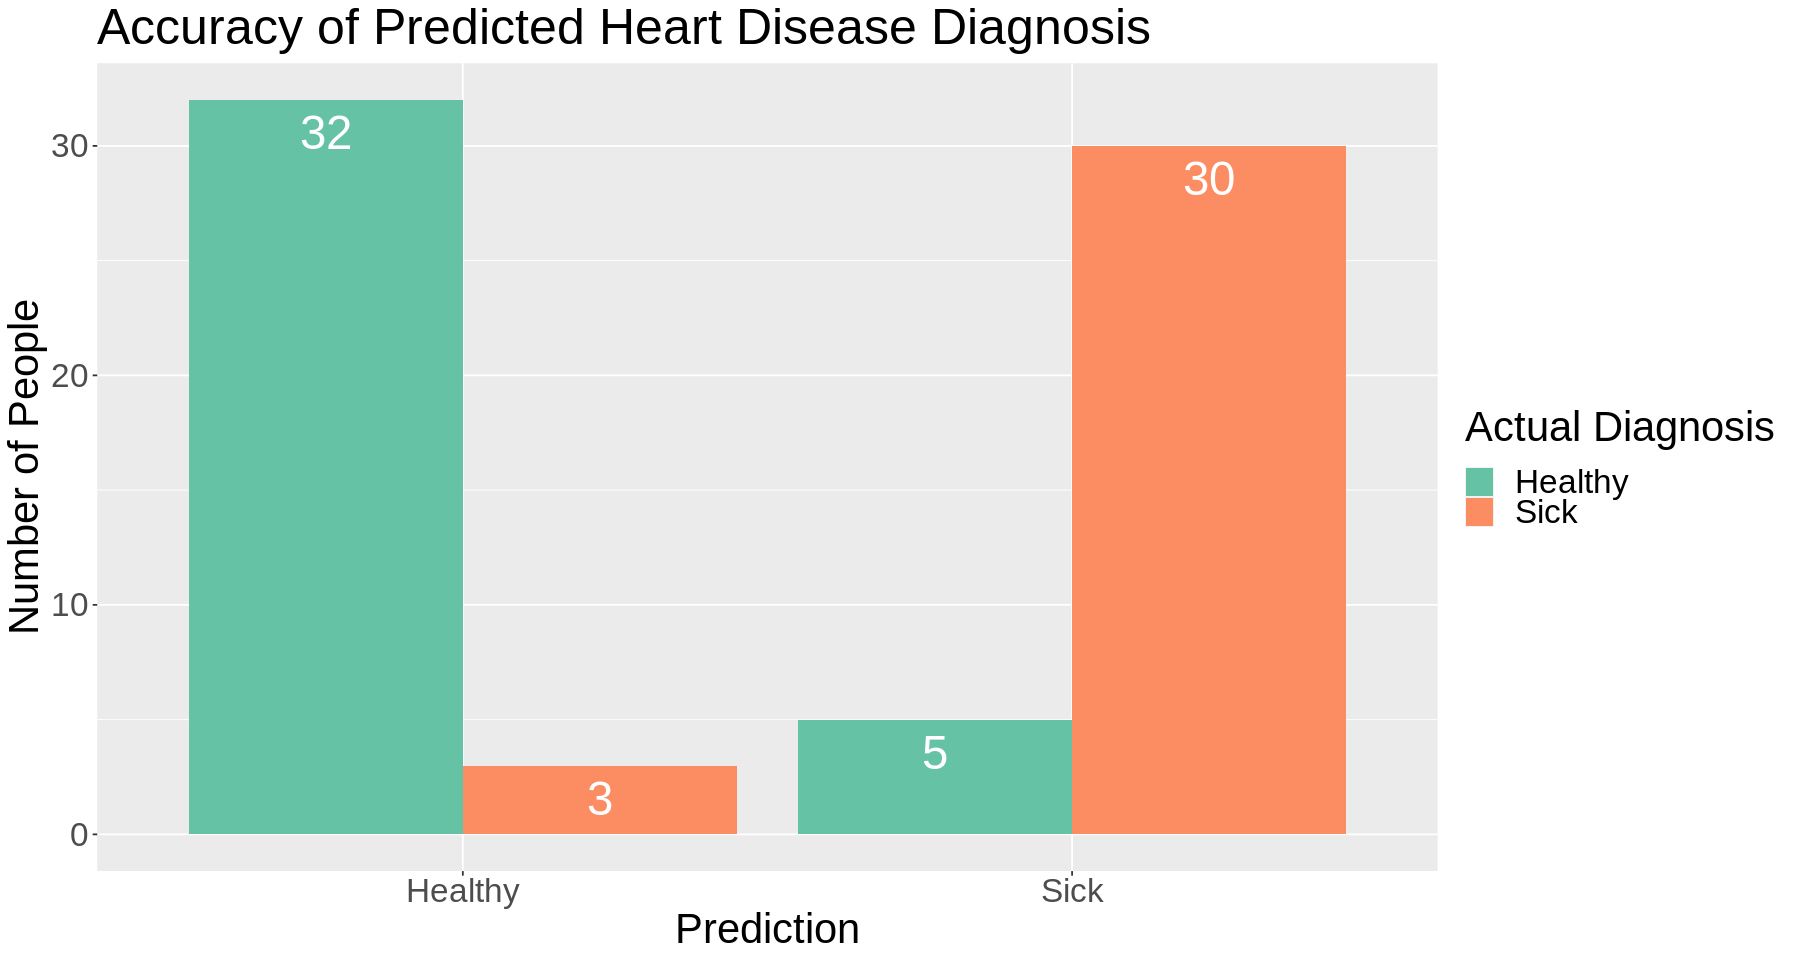

In [31]:
conf_plot <- conf|> 
as.data.frame(conf) |>
select(-class.error)|>
tibble::rownames_to_column("Prediction")|>
mutate(Prediction = case_when(Prediction == 1 ~ "Healthy" , Prediction == 2 ~ "Sick"))|>
pivot_longer(-Prediction, names_to = "Diagnosis")|>
ggplot((aes(x=Prediction,y=value,fill=Diagnosis))) + geom_bar(stat = "identity", position = "dodge") +
ylab("Number of People") +
xlab("Prediction") +
labs(fill = "Actual Diagnosis") +
ggtitle("Accuracy of Predicted Heart Disease Diagnosis") +
scale_fill_brewer(palette = "Set2") +
geom_text(aes(label = value), colour = "white", size = 10, vjust = 1.5, position = position_dodge(.9)) + 
theme(text = element_text(size = 25))
print(conf_plot)

Figure 1.2: Visualization of Classifier Accuracy

We took the confusion matrix that we reformatted from above and converted it to a data frame, we then removed the class error column, wrangled the data to make it more appropriate for the visualization, and then organized it graphically to make the above visualization of our results. As you can see the predictions of healthy and sick where the individuals were actually healthy and sick respectively far out number the number of individuals who were misdiagnosed by our classifier. 

In summary, we found that despite our classifier being fairly good at predicting the heart disease status of an individual, there are so many confounding variables that creating such a classifier is not straightforward. As we explained above, the variables that we chose were based on the amount of overlap between healthy and sick individuals graphically, despite this we needed to choose variables that had more space dedicated to sick individuals to balance the predictions as they were leaning much more towards healthy individuals. This should not be the case because this can also cause more misattributions for the healthy data, this is the effect of variables being more complicated than we first assumed. We think that what we found was expected. If it was really this simple to gather a set of variables and create a classifier with 100% accuracy for something like heart disease, this would have been the route for illness diagnosis from a long time ago. To see that we could get around 89% accuracy from our classifier far better than what was expected, but the predictions vary on how many sick individuals that it accurately predicts and how many healthy is something we expected to see. Although we can get a reading between 75% and 89% almost every time, the inconsistency that is seen with the above classifier is worrying for practical uses, again illuminating the variables being highly indistinguishable in whether they indicate the presence or absence of heart disease. 

This contradicts what we initially expected, instead of it being a defined line between what indicates the presence or absence of heart disease, there is far more overlap. Understanding that these variables are confounding has very relevant impacts. The correlations not being as clear as we first predicted makes it harder to find what individuals should alter in their everyday lives to lessen the likelihood of developing heart disease. While this could cause indivduals to want to strive for healthier lives and possibly decrease their likelihood of developing heart disease by being more proactive if they fall into the given frame of sickness, this isn't as clear as we expected. Therefore, it will not only lead to more research being dedicated to understanding the extent to which these variables confound, as well as what preventative measures one can take prior to development.   

We think that with the current understanding we have, and the classifier that we created it could lead to more questions about how predictive classifiers can be used as a simple way to give people an idea of what the likelihood of developing such a disease would be. While this might not be the end all be all of diagnosis, it is likely that there could be development where a classifier is used as a preliminary measure, prior to the actual diagnosis so that individuals who are clearly healthy can avoid having to make that doctors visit, and those that are clearly sick can get the care they need. We also believe that despite the confounding variables that we found, questions will be raised about how people choose to live their lives and how impactful their daily lifestyle choices are to their overall heart health, and health in general. Classifiers can help raise questions about what really contributes to the development of heart disease and other similar diseases, and how someone can continue to take better care of themselves even with a predisposition or diagnosis.

References

Lay out panels in a grid - facet_grid. - facet_grid • ggplot2. (n.d.). Retrieved April 8, 2023, from https://ggplot2.tidyverse.org/reference/facet_grid.html 

Plot confusion matrix as stacked bar chart with GGPLOT2. Stack Overflow. (1966, November 1). Retrieved April 8, 2023, from https://stackoverflow.com/questions/59714182/plot-confusion-matrix-as-stacked-bar-chart-with-ggplot2 

Tiffany Timbers, T. C. (2022, September 24). Data science. Chapter 6 Classification II: evaluation &amp; tuning. Retrieved April 11, 2023, from https://datasciencebook.ca/classification2.html 

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved April 8, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 